In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
from random import randint
import json
import collections

plt.style.use(["Solarize_Light2"])
plt.rcParams["axes.edgecolor"] = "#66818c"
plt.rcParams["axes.facecolor"] = "#263238"
plt.rcParams["figure.facecolor"] = "#263238"
plt.rcParams["grid.color"] = "#3f575b"
plt.rcParams["xtick.color"] = "#bfd5dd"
plt.rcParams["ytick.color"] = "#bfd5dd"
plt.rcParams["text.color"] = "#bfd5dd"
plt.rcParams["axes.labelcolor"] = "#bfd5dd"

engine = create_engine("postgresql+psycopg2://{}:{}@{}:{}/{}".format("postgres",
                                                                     "123",
                                                                     "172.17.0.2",
                                                                     "5432",
                                                                     "estimator"))

In [2]:
stations = []
with open("../../data/mos_metro.json") as file:
    metro = json.loads(file.read())
    for line in metro["lines"]:
        for station in line["stations"]:
            stations.append({
                "name": station["name"],
                "line": line["name"],
                "lat": station["lat"],
                "lng": station["lng"]
            })
    stations = pd.DataFrame(stations)
    stations = stations[~stations.lng.isin([55.708831, 40.976995, 55.776667])]

In [3]:
cost = lambda y_, y: 1/len(y) * sum((y_-y)**2)

In [51]:
def gradient(columns=['street', 'ppm', 'stations', 'lng', 'lat']):
    flt = (df.ppm < df.ppm.median() + 10 * df.ppm.std())
    X = df[flt].drop(columns, axis=True)
    y = df[flt].ppm
    X = ((X-X.mean())/X.std()).values
    y = ((y-y.mean())/y.std()).values
    epoch = 300000
    step = 100
    w = [0] * X.shape[1]
    errs = []
    for e in range(epoch):
        s = X.shape[0]
        i = randint(0, s-1)
        w -= (step/(s+10*e) * (X[i].dot(w)-y[i])) * (X[i])
    print(sum((X.dot(w)-y)**2)/len(y))
    return w, X, y

In [5]:
query = """ SELECT flat.id,
                   owner_type,
                   price,
                   area,
                   area_kitchen,
                   area_living,
                   floor,
                   rooms,
                   layout,
                   height,
                   bathrooms,
                   window_types,
                   balconies,
                   condition,
                   district,
                   street,
                   year,
                   material,
                   floors,
                   elevators,
                   parkings,
                   garbage_chute,
                   heating_type,
                   lng,
                   lat
            FROM flat
            INNER JOIN building ON building_id = building.id
            WHERE NOT district IS NULL
        """
df = pd.read_sql(query, engine)
df.loc[:, "ppm"] = df.price / df.area
df.loc[:, "bathrooms_0"] = df.bathrooms.apply(lambda i: None if i is None else i[0])
df.loc[:, "bathrooms_1"] = df.bathrooms.apply(lambda i: None if i is None else i[1])
df.loc[:, "window_types_0"] = df.window_types.apply(lambda i: None if i is None else i[0])
df.loc[:, "window_types_1"] = df.window_types.apply(lambda i: None if i is None else i[1])
df.loc[:, "balconies_0"] = df.balconies.apply(lambda i: None if i is None else i[0])
df.loc[:, "balconies_1"] = df.balconies.apply(lambda i: None if i is None else i[1])
df.loc[:, "elevators_0"] = df.elevators.apply(lambda i: None if i is None else i[0])
df.loc[:, "elevators_1"] = df.elevators.apply(lambda i: None if i is None else i[1])
df.loc[:, "elevators_2"] = df.elevators.apply(lambda i: None if i is None else i[2])
df.drop("price", inplace=True, axis=True)
df.drop("bathrooms", inplace=True, axis=True)
df.drop("window_types", inplace=True, axis=True)
df.drop("balconies", inplace=True, axis=True)
df.drop("elevators", inplace=True, axis=True)
print("height", df[df.height.isnull()].height.shape[0], end="-")
for lng, lat in df[df.height.isnull()][["lng", "lat"]].values:
    l = df[(df.lng==lng) & (df.lat==lat) & ~df.height.isnull()].height.values
    if len(l):
        df.loc[(df.lng==lng) & (df.lat==lat) & df.height.isnull(), "height"] = np.median(l)
print(df[df.height.isnull()].height.shape[0])
print("area_kitchen", df[df.area_kitchen.isnull()].shape[0], end="-")
for lng, lat, rooms in df[df.area_kitchen.isnull()][["lng", "lat", "rooms"]].values:
    l = df[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & ~df.area_kitchen.isnull()].area_kitchen.values
    if len(l):
        l = [(item, count) for item, count in collections.Counter(l).items() if count > 1]
        if len(l):
            l = sorted(l, key=lambda x: x[1], reverse=True)
            df.loc[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & df.area_kitchen.isnull(), "area_kitchen"] = l[0][0]
print(df[df.area_kitchen.isnull()].shape[0])
print("area_living", df[df.area_living.isnull()].shape[0], end="-")
for lng, lat, rooms in df[df.area_living.isnull()][["lng", "lat", "rooms"]].values:
    l = df[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & ~df.area_living.isnull()].area_living.values
    if len(l):
        l = [(item, count) for item, count in collections.Counter(l).items() if count > 1]
        if len(l):
            l = sorted(l, key=lambda x: x[1], reverse=True)
            df.loc[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & df.area_living.isnull(), "area_living"] = l[0][0]
print(df[df.area_living.isnull()].shape[0])
print("layout", df[df.layout.isnull()].shape[0], end="-")
for lng, lat, rooms in df[df.layout.isnull()][["lng", "lat", "rooms"]].values:
    l = df[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & ~df.layout.isnull()].layout.values
    if len(l):
        l = [(item, count) for item, count in collections.Counter(l).items() if count > 1]
        if len(l):
            l = sorted(l, key=lambda x: x[1], reverse=True)
            df.loc[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & df.layout.isnull(), "layout"] = l[0][0]
print(df[df.layout.isnull()].shape[0])
print("bathrooms_0", df[df.bathrooms_0.isnull()].shape[0], end="-")
for lng, lat, rooms in df[df.bathrooms_0.isnull()][["lng", "lat", "rooms"]].values:
    l = df[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & ~df.bathrooms_0.isnull()].bathrooms_0.values
    if len(l):
        l = [(item, count) for item, count in collections.Counter(l).items() if count > 1]
        if len(l):
            l = sorted(l, key=lambda x: x[1], reverse=True)
            df.loc[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & df.bathrooms_0.isnull(), "bathrooms_0"] = l[0][0]
print(df[df.bathrooms_0.isnull()].shape[0])
print("bathrooms_1", df[df.bathrooms_1.isnull()].shape[0], end="-")
for lng, lat, rooms in df[df.bathrooms_1.isnull()][["lng", "lat", "rooms"]].values:
    l = df[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & ~df.bathrooms_1.isnull()].bathrooms_1.values
    if len(l):
        l = [(item, count) for item, count in collections.Counter(l).items() if count > 1]
        if len(l):
            l = sorted(l, key=lambda x: x[1], reverse=True)
            df.loc[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & df.bathrooms_1.isnull(), "bathrooms_1"] = l[0][0]
print(df[df.bathrooms_1.isnull()].shape[0])
print("garbage_chute", df[df.garbage_chute.isnull()].shape[0], end="-")
for lng, lat in df[df.garbage_chute.isnull()][["lng", "lat"]].values:
    l = df[(df.lng==lng) & (df.lat==lat) & ~df.garbage_chute.isnull()].garbage_chute.values
    l = [(item, count) for item, count in collections.Counter(l).items() if count > 1]
    if len(l):
        l = sorted(l, key=lambda x: x[1], reverse=True)
        df.loc[(df.rooms==rooms) & (df.lng==lng) & (df.lat==lat) & df.garbage_chute.isnull(), "garbage_chute"] = l[0][0]
print(df[df.garbage_chute.isnull()].shape[0])
columns = ["bathrooms_0", "bathrooms_1", "window_types_0", "window_types_1", "balconies_0", "balconies_1", "elevators_0", "elevators_1", "elevators_2"]
df.loc[:, columns] = df[columns].fillna(0)
columns = ["owner_type", "condition", "district", "layout", "material", "garbage_chute", "heating_type", "rooms", "parkings"]
for column in columns:
    for value in df.loc[~df[column].isnull(), column].unique():
        df.loc[df[column] == value, column + "_" + str(int(value))] = True
        df.loc[:, column + "_" + str(int(value))] = df[column + "_" + str(int(value))].fillna(False)
    df.drop(column, axis=True, inplace=True)
columns = ["district_0", "district_11", "district_2", "district_6", "district_5", "district_7", "district_3", "district_8", "district_1", "district_10", "district_4", "district_9"]
for district in columns:
    df.loc[df.year.isnull() & df[district]==True, "year"] = df.loc[~df.year.isnull() & df[district]==True].groupby("year")["year"].count().sort_values(ascending=False).index[0]
columns = ["rooms_1", "rooms_2", "rooms_3", "rooms_4", "rooms_5", "rooms_6"]
for column in columns:
    df.loc[df.area_kitchen.isnull() & df[column]==True, "area_kitchen"] = df.loc[~df.area_kitchen.isnull() & df[column]==True, "area_kitchen"].median()
    df.loc[df.area_living.isnull() & df[column]==True, "area_living"] = df.loc[~df.area_living.isnull() & df[column]==True, "area_living"].median()
z_lng = df.sort_values("ppm", ascending=False)[:500].lng.mean()
z_lat = df.sort_values("ppm", ascending=False)[:500].lat.mean()
df.loc[:, "from_center"] = 1/((df.lng - z_lng)**2 + (df.lat-z_lat)**2)**.5
df.height = df.height.fillna(df.height.median())
print(df.shape)

height 16092-6008
area_kitchen 6949-4840
area_living 5897-4135
layout 24866-21583
bathrooms_0 5583-3094
bathrooms_1 5583-3074
garbage_chute 12099-11956
(33067, 67)


In [6]:
distances = {}
for lat, lng in df.set_index(["lat", "lng"]).index.unique():
    distances[(lat, lng)] = dict()
    for _, station in stations.iterrows():
        distances[(lat, lng)][station["name"]] = ((station.lng-lng)**2+(station.lat-lat)**2)**.5
df = df.set_index(["lat", "lng"])
df.loc[:, "stations"] = pd.Series(distances).apply(lambda x: {k: v for k, v in sorted(x.items(), key=lambda item: item[1])})
df = df.reset_index()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [7]:
for street, value in df.groupby("street").ppm.mean().items():
    df.loc[df.street==street, "street_mean"] = value

In [8]:
w, _, _ = gradient()

0.16869826598671708


In [9]:
df.loc[:, "stations_1"] = df.loc[:, "stations"].apply(lambda x: 1/np.mean(list(x.values())[:1]))
# df.loc[:, "stations_2"] = df.loc[:, "stations"].apply(lambda x: 1/np.mean(list(x.values())[:2]))
df.loc[:, "stations_3"] = df.loc[:, "stations"].apply(lambda x: 1/np.mean(list(x.values())[:3]))
# df.loc[:, "stations_5"] = df.loc[:, "stations"].apply(lambda x: 1/np.mean(list(x.values())[:5]))
df.loc[:, "stations_8"] = df.loc[:, "stations"].apply(lambda x: 1/np.mean(list(x.values())[:8]))
df.loc[:, "stations_13"] = df.loc[:, "stations"].apply(lambda x: 1/np.mean(list(x.values())[:13]))

In [10]:
w, _, _ = gradient()

0.16669364253239521


In [11]:
df.loc[:, "street_and_center"] = df.street_mean * df.from_center

In [12]:
w, _, _ = gradient()

0.16463515171441695


In [13]:
df.loc[:, "space"] = 1/(df.area / df[["rooms_1", "rooms_2", "rooms_3", "rooms_4", "rooms_5", "rooms_6"]].apply(lambda rooms: sum([i+1 for i, r in enumerate(rooms.values) if r > 0]), axis=1))

In [14]:
w, _, _ = gradient()

0.1642871993271698


In [15]:
street_ppm = df.groupby("street").ppm.mean()
exp_street = street_ppm[street_ppm > 340000].index
df.loc[:, "exp_street"] = df.street.isin(exp_street)

In [16]:
w, _, _ = gradient()

0.1627578783384049


In [17]:
exp_stations = df.sort_values("ppm", ascending=False).stations.apply(lambda x: list(x.keys())[0]).unique()[:10]
def sum_stations(item):
    x = 0
    for st in exp_stations:
        x+= item[st]
    return x
df.loc[:, "sum_stations"] = 1 / df.stations.apply(sum_stations)

In [18]:
w, _, _ = gradient()

0.16238061576667295


In [20]:
# for area, err in df.groupby(df.area//10).error.mean().items():
#     df.loc[df.area//10==area, "area_err"] = err

In [21]:
# w, _, _ = gradient()
# 0.1600503417578648

In [22]:
# for year, err in df.groupby(df.year).error.mean().items():
#     df.loc[df.year==year, "year_err"] = err

In [23]:
# w, _, _ = gradient()
# 0.1588810318607235

In [24]:
# for area_kitchen, err in df.groupby(df.area_kitchen//10).error.mean().items():
#     df.loc[df.area_kitchen//10==area_kitchen, "area_kitchen_err"] = err

In [25]:
# w, _, _ = gradient()
# 0.15844961739816257

In [26]:
# for area_living, err in df.groupby(df.area_living//10).error.mean().items():
#     df.loc[df.area_living//10==area_living, "area_living_err"] = err

In [27]:
# w, _, _ = gradient()
# 0.15787563233702714

In [28]:
# for area_living, err in df.groupby(df.area_living//10).error.mean().items():
#     df.loc[df.area_living//10==area_living, "area_living"] = err

In [29]:
# w, _, _ = gradient()
# 0.1581073615689704

In [30]:
df.loc[:, "stations_1_mean"] = df.stations_1 > df.stations_1.mean()
df.loc[:, "stations_13_mean"] = df.stations_13 > df.stations_13.mean()
df.loc[:, "stations_8_mean"] = df.stations_8 > df.stations_8.mean()
df.loc[:, "area_to_mean"] = df.area > df.area.mean()
df.loc[:, "from_center_to_mean"] = df.from_center > df.from_center.mean()

# df.loc[:, "year_1990"] = df.year > 1990
# df.loc[:, "floor_mean"] = df.floor < 10
# df.loc[:, "floors_mean"] = (df.floors > 5) & (df.floors < 15)
# df.loc[:, "floors_to_floor"] = df.floors / df.floor
# df.loc[:, "floor_to_floors"] = df.floor / df.floors
# df.loc[:, "area_living_to_mean"] = df.area_living > df.area_living.mean()
# df.loc[:, "height_to_mean"] = df.height > df.height.mean()
# df.loc[:, "bathrooms_0_to_mean"] = df.bathrooms_0 > df.bathrooms_0.mean()
# df.loc[:, "bathrooms_0_to_mean"] = df.bathrooms_1 > df.bathrooms_1.mean()
# df.loc[:, "bathrooms_to_mean"] = (df.bathrooms_0 + df.bathrooms_1) > (df.bathrooms_0 + df.bathrooms_1).mean()
# df.loc[:, "sum_stations_mean"] = df.sum_stations > df.sum_stations.mean()
# c_m = df.from_center.mean()
# r = {}
# for idx, item in df.iterrows():
#     r[idx] = 1 if item.from_center > c_m * 1.5 else 0
# df.loc[:, "from_center_mean"] = pd.Series(r)
# df.columns

In [53]:
w, X, y = gradient(['street', 'ppm', 'stations', 'lng', 'lat', 'error', 'ppm_e'])

0.1619771286265007


(33045, 31604)

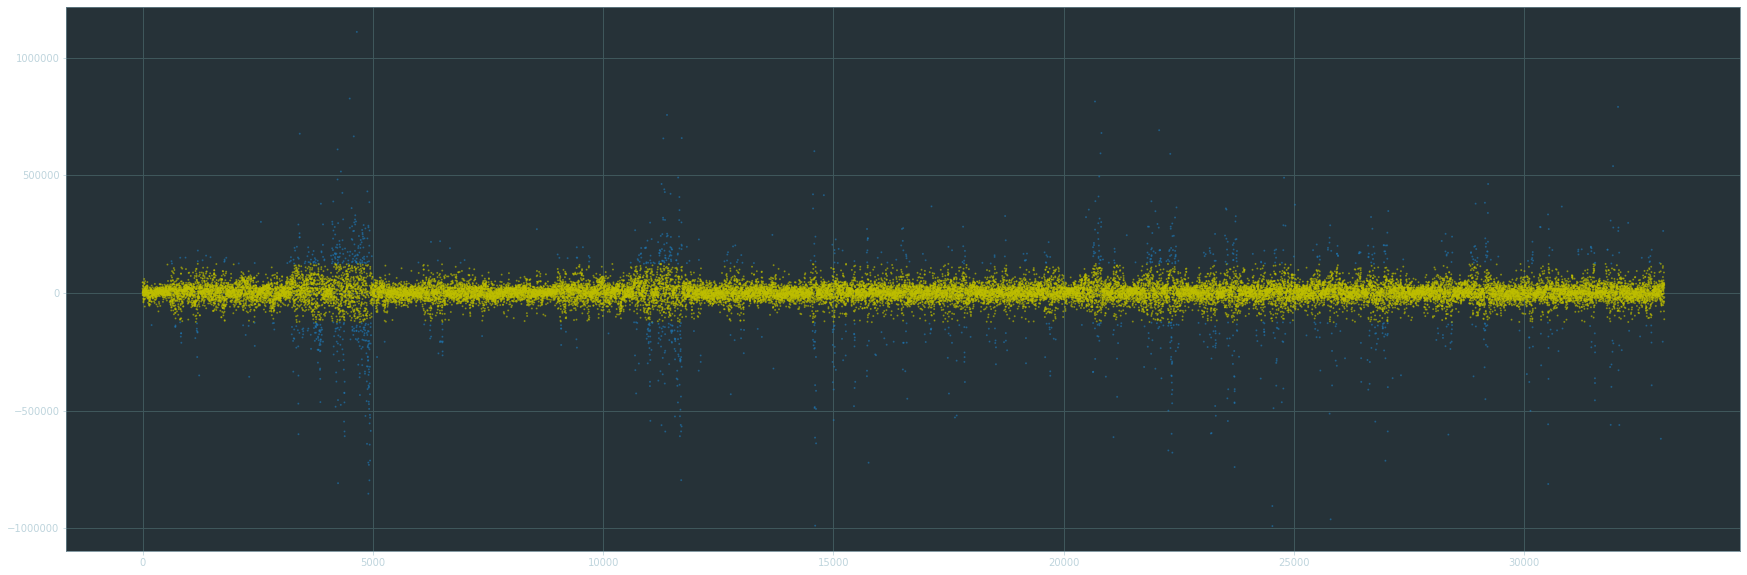

In [54]:
flt = (df.ppm < df.ppm.median() + 10 * df.ppm.std())
limit = df.ppm.mean()/2
y_error_rub = X.dot(w) * df[flt].ppm.std() + df[flt].ppm.mean() - df[flt].ppm
plt.figure(figsize=(30, 10))
plt.scatter(range(len(y)), y_error_rub, alpha=.5, s=1, c=["y" if c > -limit and c < limit else "#1f77b4" for c in y_error_rub])
len(y), len([ i for i in y_error_rub.values if i > -limit and i < limit ])
# (32613, 23749)

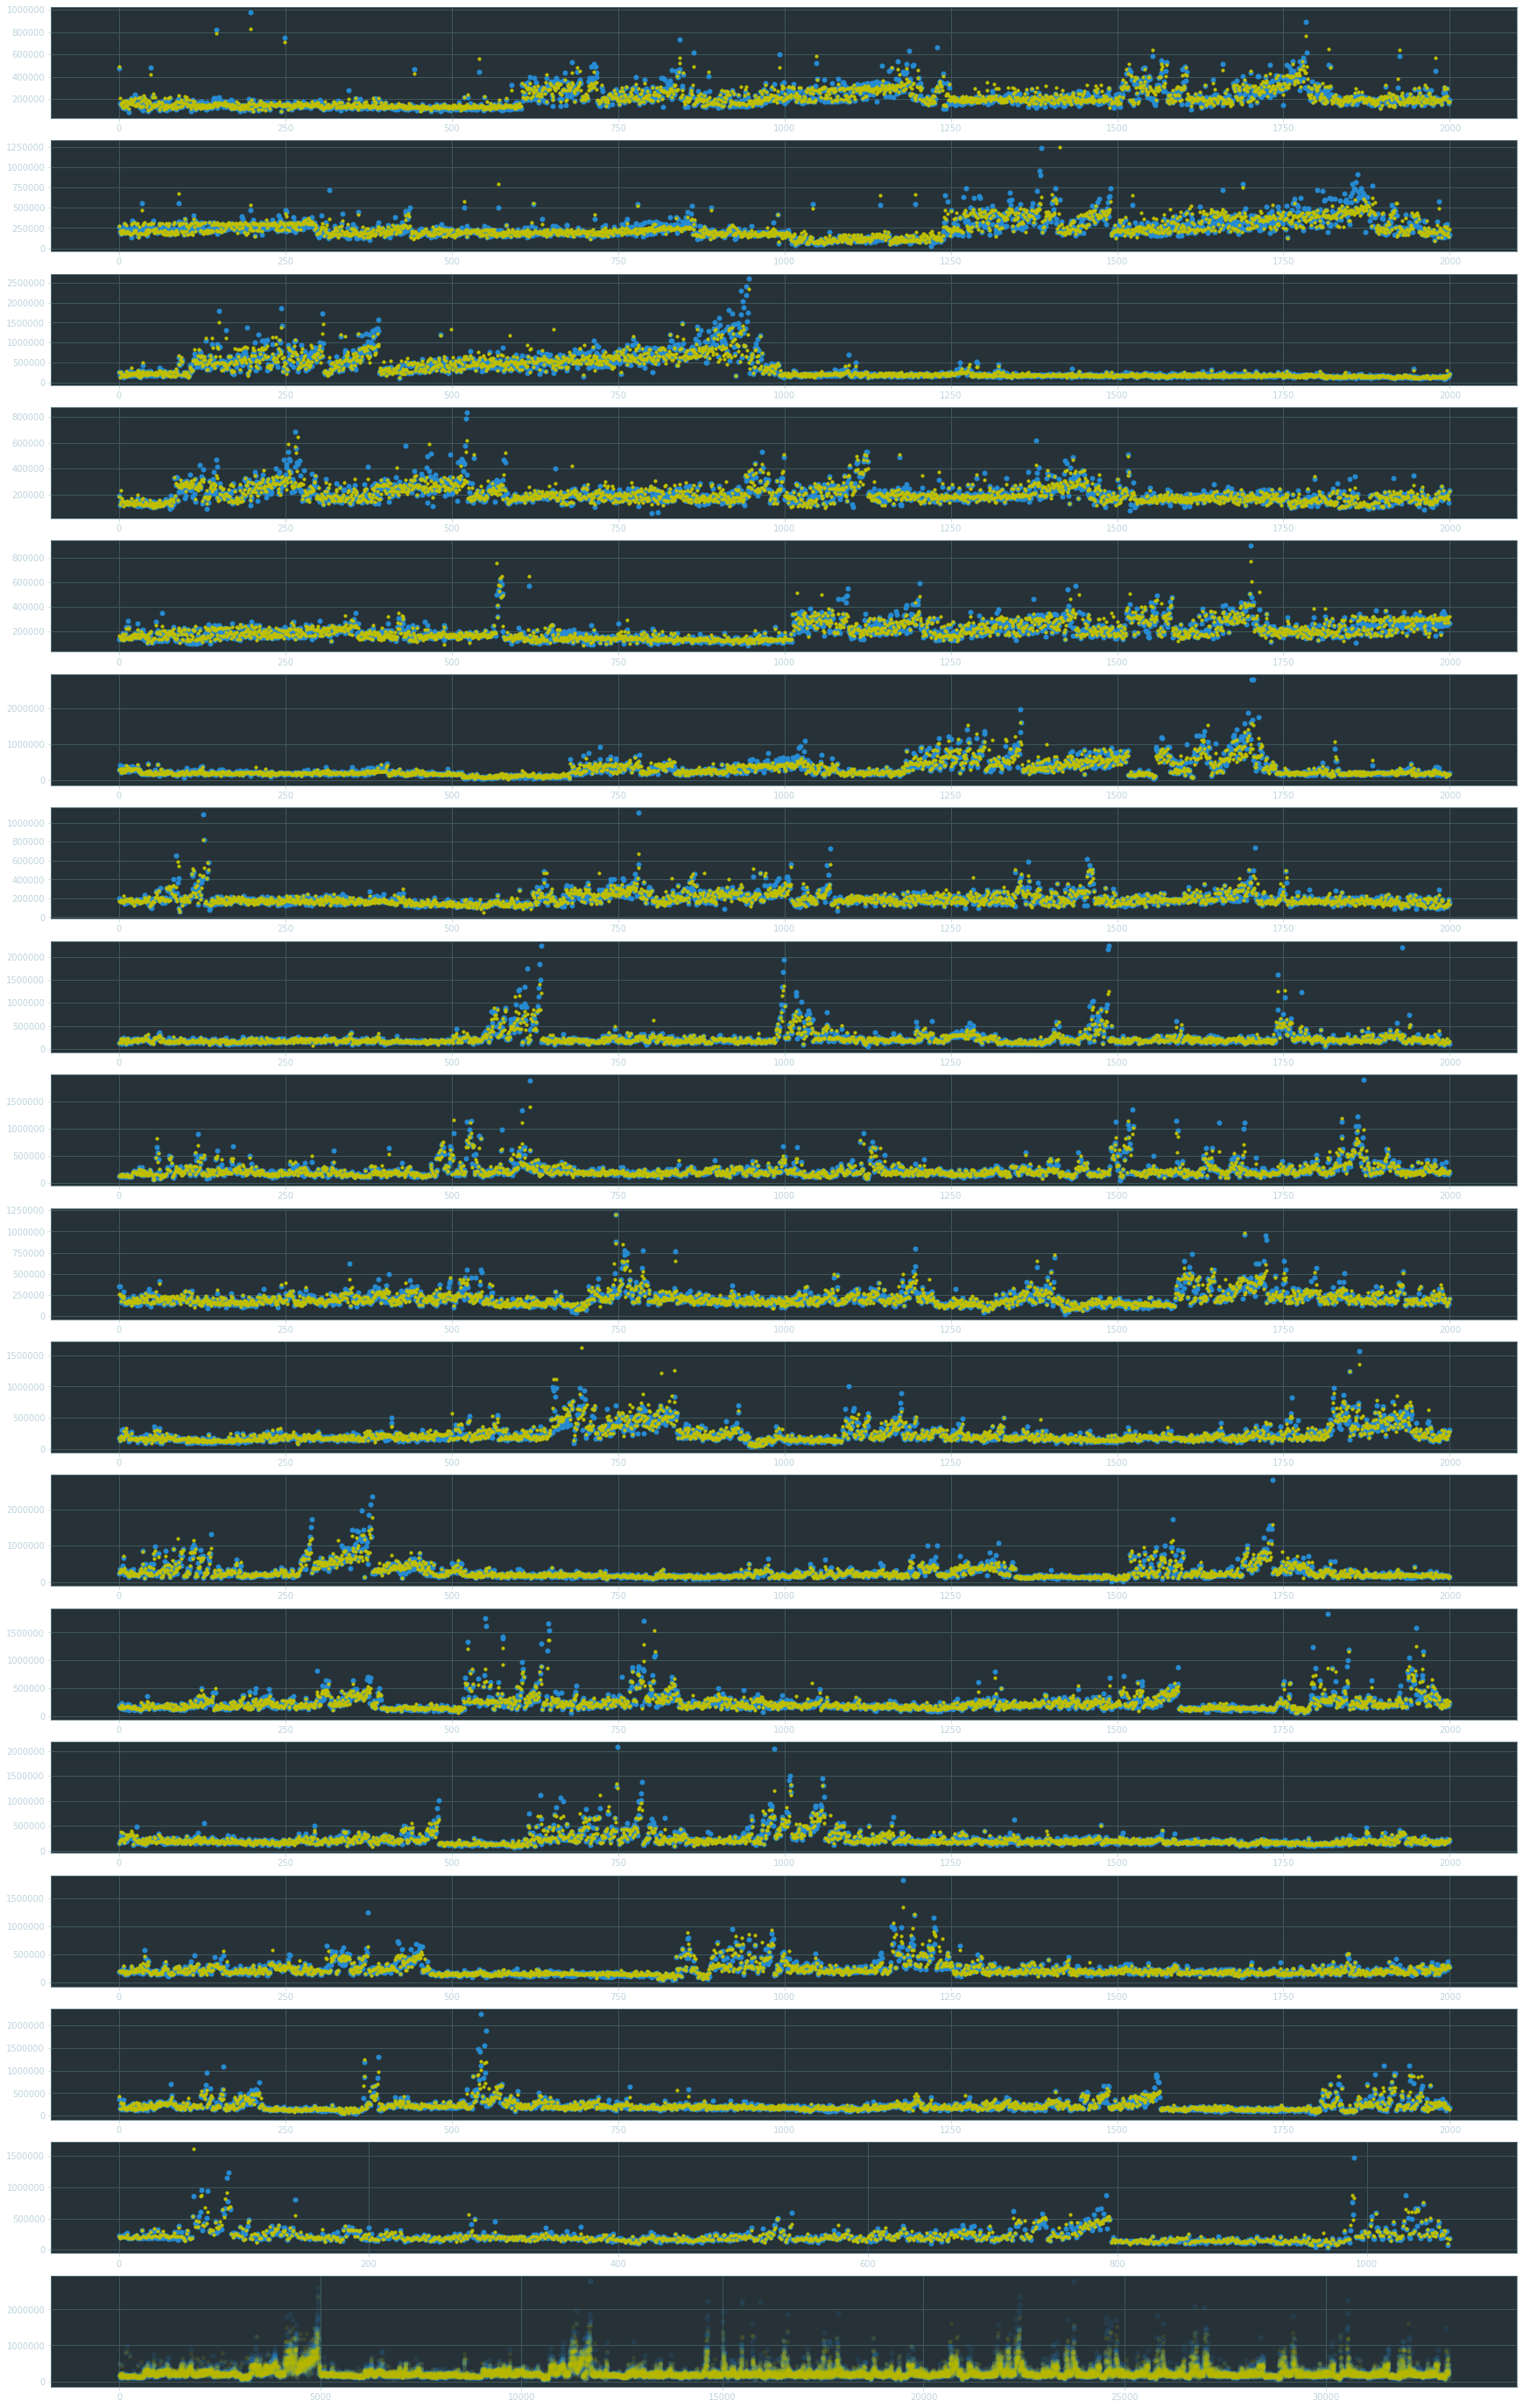

In [71]:
X_w = X.dot(w) * df[flt].ppm.std() + df[flt].ppm.mean()
fig, plts = plt.subplots(nrows=18, ncols=1, figsize=(30, 50))

plts[17].scatter(range(df.loc[:, "ppm"].shape[0]), df.loc[:, "ppm"], s=25, alpha=.1)
plts[17].scatter(range(df.loc[:, "ppm"].shape[0]), X_w, s=15, c="y", alpha=.1)

plts[0].scatter(range(2000), df.loc[:, "ppm"][:2000], s=25)
plts[0].scatter(range(2000), X_w[:2000], s=10, c="y")
plts[1].scatter(range(2000), df.loc[:, "ppm"][2000:4000], s=25)
plts[1].scatter(range(2000), X_w[2000:4000], s=10, c="y")
plts[2].scatter(range(2000), df.loc[:, "ppm"][4000:6000], s=25)
plts[2].scatter(range(2000), X_w[4000:6000], s=10, c="y")
plts[3].scatter(range(2000), df.loc[:, "ppm"][6000:8000], s=25)
plts[3].scatter(range(2000), X_w[6000:8000], s=10, c="y")
plts[4].scatter(range(2000), df.loc[:, "ppm"][8000:10000], s=25)
plts[4].scatter(range(2000), X_w[8000:10000], s=10, c="y")
plts[5].scatter(range(2000), df.loc[:, "ppm"][10000:12000], s=25)
plts[5].scatter(range(2000), X_w[10000:12000], s=10, c="y")
plts[6].scatter(range(2000), df.loc[:, "ppm"][12000:14000], s=25)
plts[6].scatter(range(2000), X_w[12000:14000], s=10, c="y")
plts[7].scatter(range(2000), df.loc[:, "ppm"][14000:16000], s=25)
plts[7].scatter(range(2000), X_w[14000:16000], s=10, c="y")
plts[8].scatter(range(2000), df.loc[:, "ppm"][16000:18000], s=25)
plts[8].scatter(range(2000), X_w[16000:18000], s=10, c="y")
plts[9].scatter(range(2000), df.loc[:, "ppm"][18000:20000], s=25)
plts[9].scatter(range(2000), X_w[18000:20000], s=10, c="y")
plts[10].scatter(range(2000), df.loc[:, "ppm"][20000:22000], s=25)
plts[10].scatter(range(2000), X_w[20000:22000], s=10, c="y")
plts[11].scatter(range(2000), df.loc[:, "ppm"][22000:24000], s=25)
plts[11].scatter(range(2000), X_w[22000:24000], s=10, c="y")
plts[12].scatter(range(2000), df.loc[:, "ppm"][24000:26000], s=25)
plts[12].scatter(range(2000), X_w[24000:26000], s=10, c="y")
plts[13].scatter(range(2000), df.loc[:, "ppm"][26000:28000], s=25)
plts[13].scatter(range(2000), X_w[26000:28000], s=10, c="y")
plts[14].scatter(range(2000), df.loc[:, "ppm"][28000:30000], s=25)
plts[14].scatter(range(2000), X_w[28000:30000], s=10, c="y")
plts[15].scatter(range(2000), df.loc[:, "ppm"][30000:32000], s=25)
plts[15].scatter(range(2000), X_w[30000:32000], s=10, c="y")

plts[16].scatter(range(len(df.loc[:, "ppm"][32000:])), df.loc[:, "ppm"][32000:], s=25)
plts[16].scatter(range(len(df.loc[:, "ppm"][32000:])), X_w[32000:], s=10, c="y");

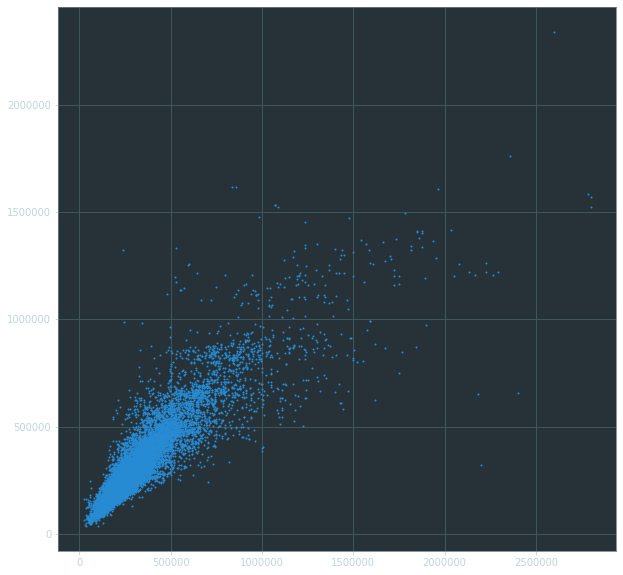

In [72]:
plt.figure(figsize=(10, 10))
plt.scatter(df.ppm, X_w, s=1);

In [73]:
X = df.drop(['street', 'ppm', 'stations', 'lng', 'lat', 'error', 'ppm_e'], axis=True)
y = df.ppm
X = ((X-X.mean())/X.std())
y = ((y-y.mean())/y.std())
s = df.ppm.std()
m = df.ppm.mean()

In [74]:
df.loc[:, "ppm_e"] = X.apply(lambda x: x.values.dot(w) * s + m, axis=1)

In [75]:
df.loc[:, "error"] = df.ppm - df.ppm_e

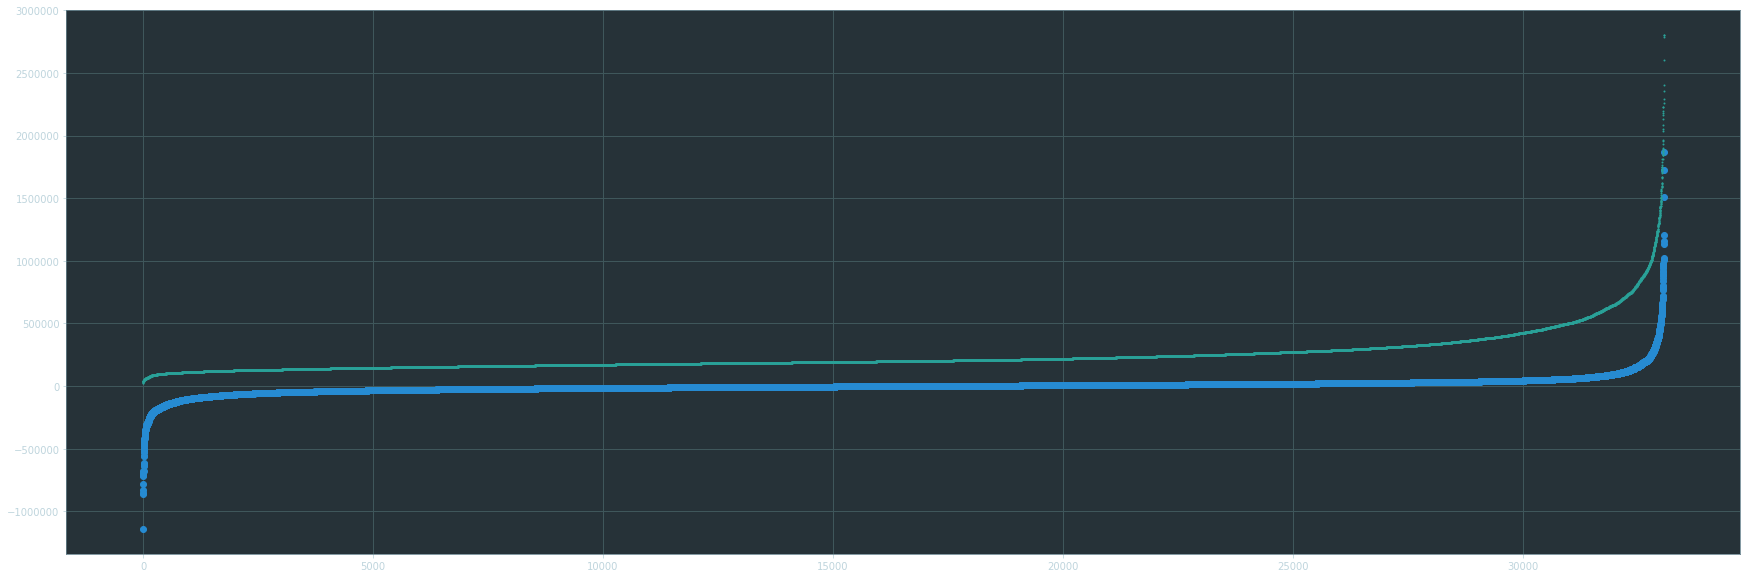

In [76]:
plt.figure(figsize=(30, 10))
plt.scatter(range(df.shape[0]), df.error.sort_values());
plt.scatter(range(df.shape[0]), df.ppm.sort_values(), s=1);

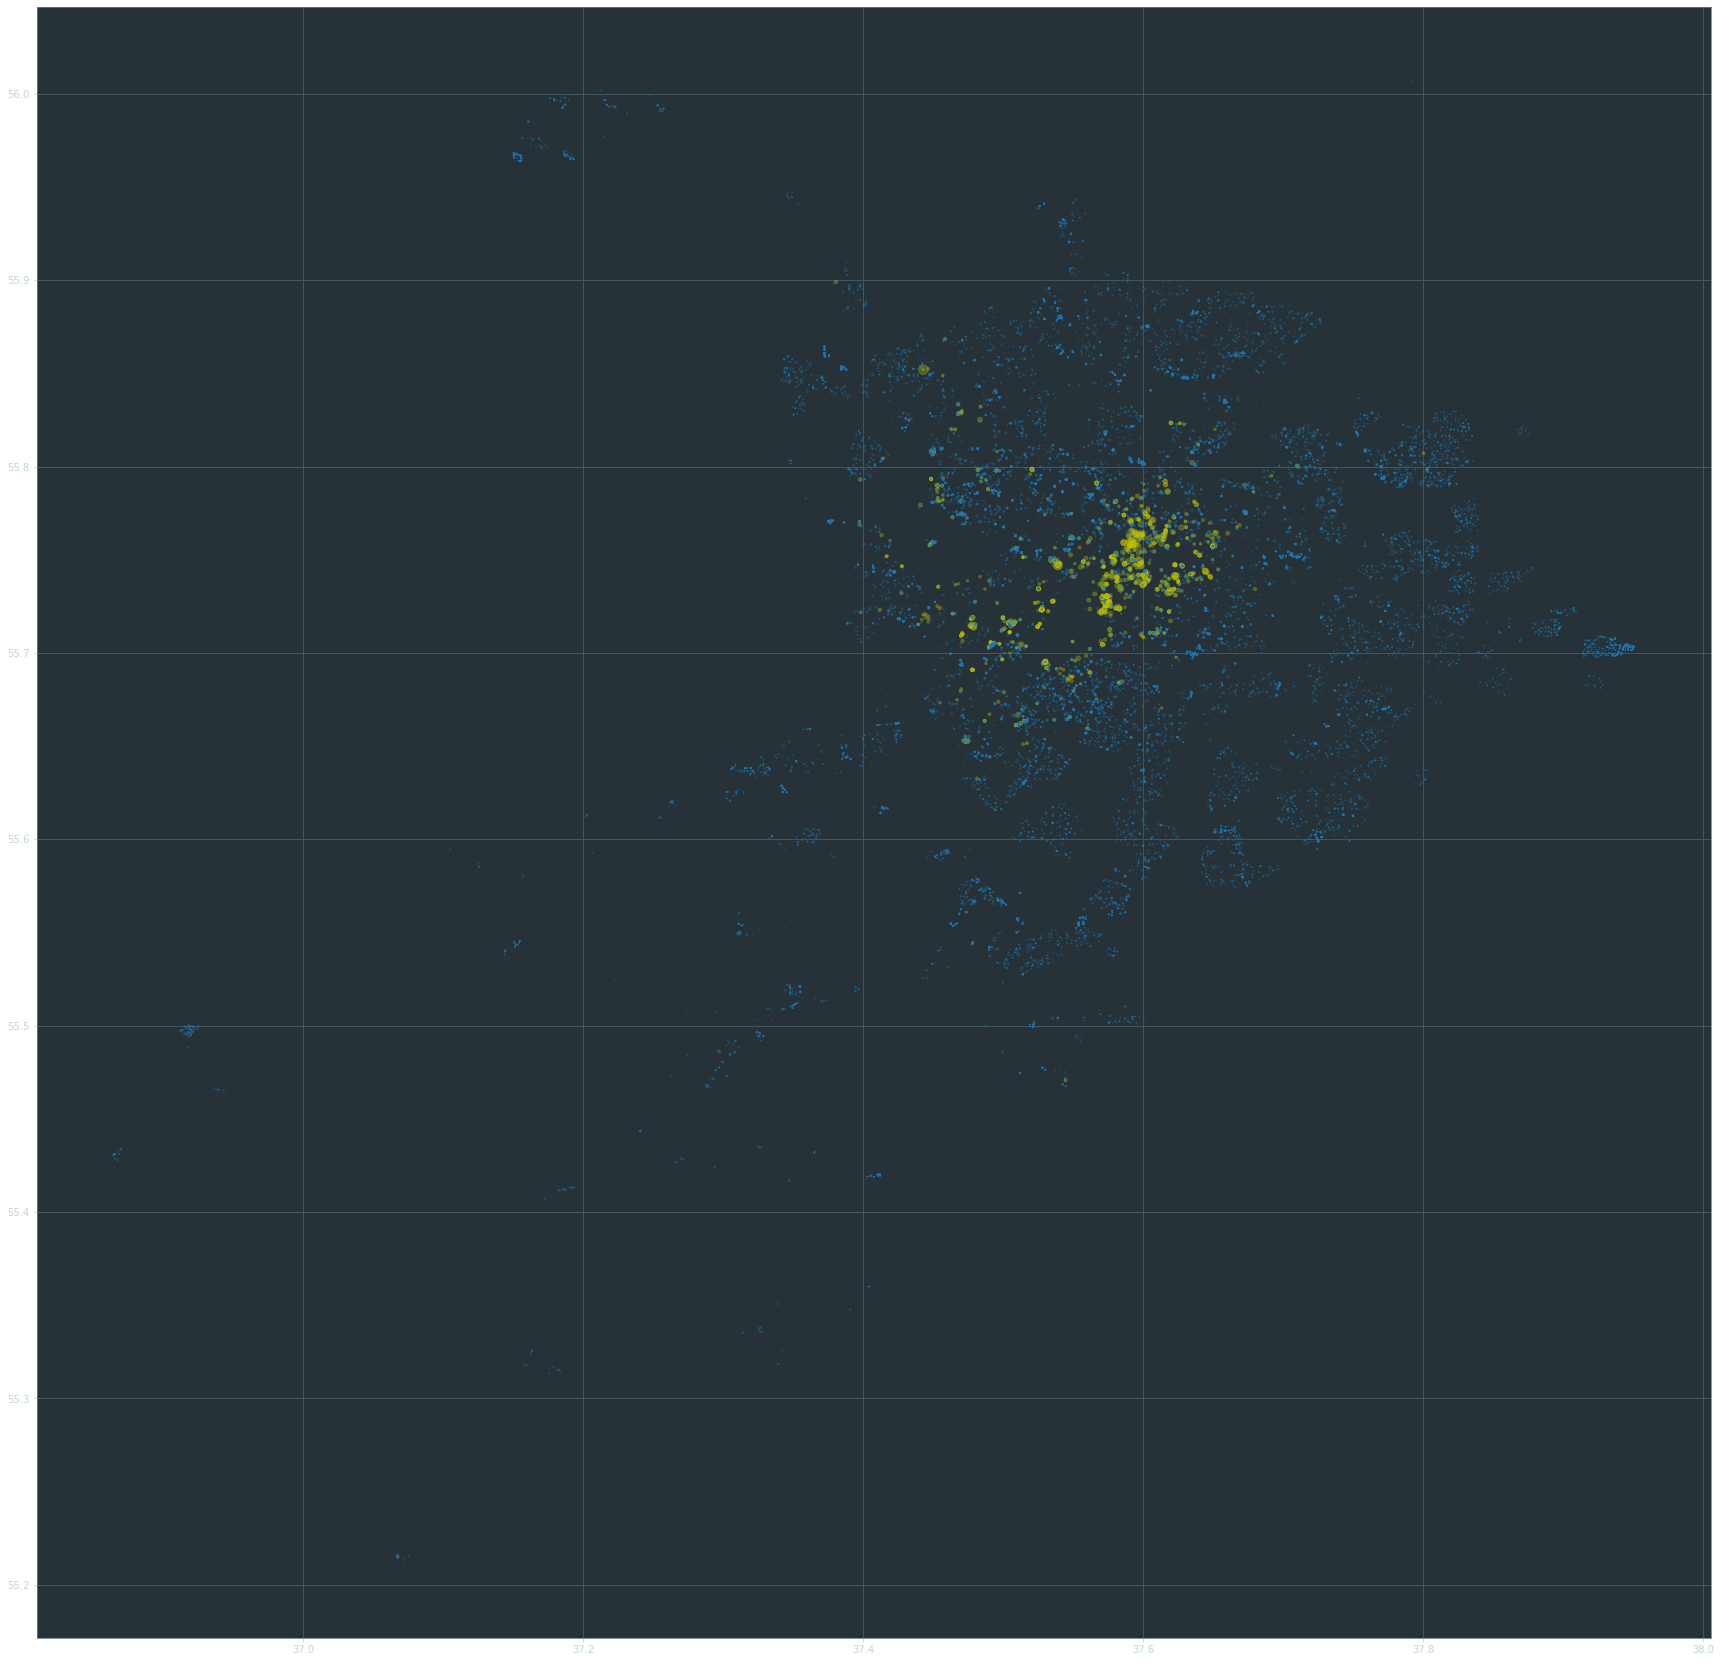

In [77]:
plt.figure(figsize=(30, 30))
plt.scatter(df.lng, df.lat, c=["y" if e > limit or e < -limit else "#1f77b4" for e in df.error], s=((df.error**2)**.5)/20000, alpha=.3);